<a href="https://colab.research.google.com/github/PeinHatake/GAN/blob/master/CGAN_MNIST_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implementation of Conditional GANs**

Tài liệu: https://arxiv.org/pdf/1411.1784.pdf

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 4),
            self.gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size = 4, stride = 1),
            self.gen_block(hidden_dim * 2, hidden_dim),
            self.gen_block(hidden_dim, im_chan, kernel_size = 4, final_layer = True)
        )

    # def gen_block
    def gen_block(self, in_channel, out_channel, kernel_size = 3, stride = 2, final_layer = False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, kernel_size = kernel_size, stride = stride),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride),
                nn.Tanh()
            )
            
    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        result = self.gen(x)
        return result

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(im_chan, hidden_dim),
            self.disc_block(hidden_dim, hidden_dim * 2),
            self.disc_block(hidden_dim * 2, 1, final_layer = True)
        )

    # def disc_block
    def disc_block(self, in_channel, out_channel, kernel_size = 4, stride = 2, final_layer = False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size, stride),
                nn.BatchNorm2d(out_channel),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size, stride)
            )
    
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [ ]:
# one-hot vector
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
  	return F.one_hot(labels, n_classes)
   
# latent vector
def combine_vectors(x, y):
  combined = torch.cat((x.float(), y.float()), 1)
  return combined

In [ ]:
mnist_shape = (1, 28, 28)
n_classes = 10

criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cpu'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

dataloader = DataLoader(
    MNIST('.', download = True, transform = transform),
    batch_size = batch_size,
    shuffle = True
    )

In [ ]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes

    return generator_input_dim, discriminator_im_chan

generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(z_dim = generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr)
disc = Discriminator(im_chan = discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr = lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow = 5, show = True):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow = nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 2.191473240017891, Discriminator loss: 0.247879630420357


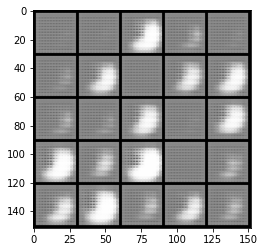

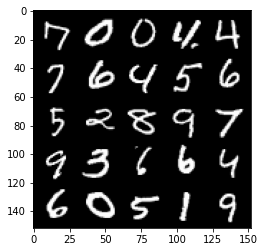

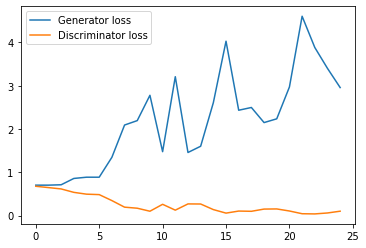

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 4.287416763782502, Discriminator loss: 0.031159457109868526


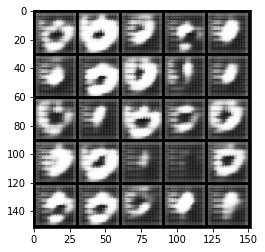

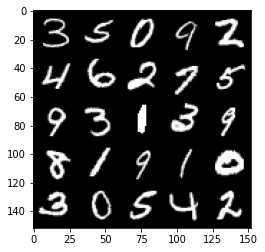

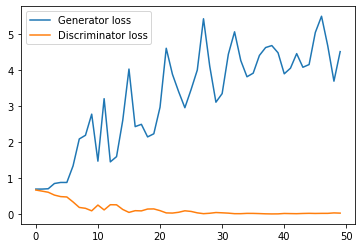

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 3.9926537079811095, Discriminator loss: 0.06338467916287482


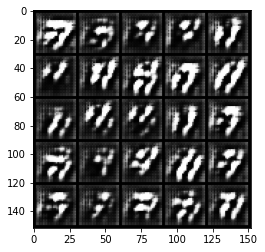

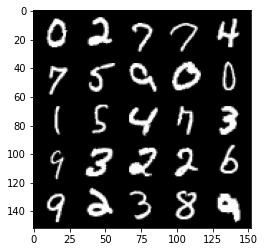

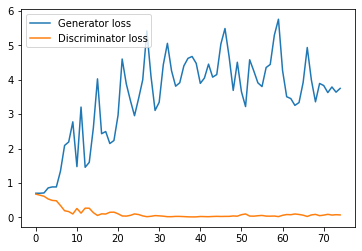

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 2.9716122329235075, Discriminator loss: 0.14615792901068925


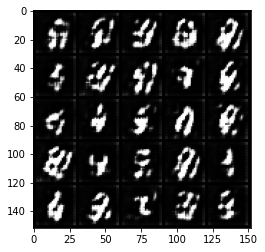

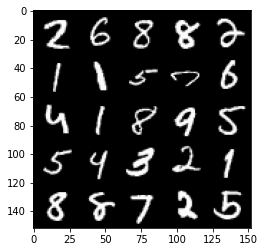

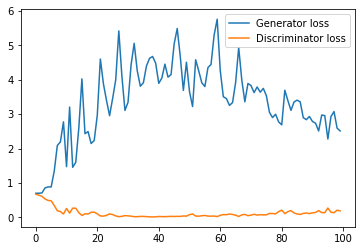

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 2.659016134023666, Discriminator loss: 0.2329322659522295


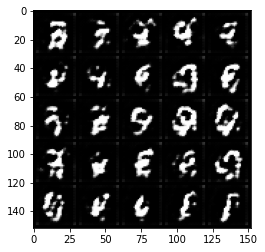

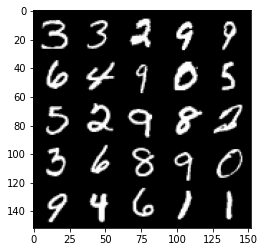

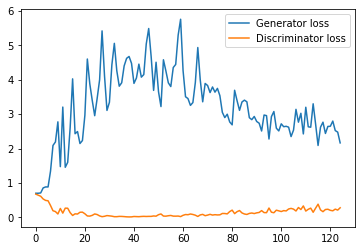

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.432221571445465, Discriminator loss: 0.24769144685566424


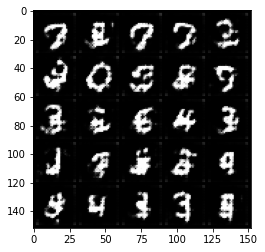

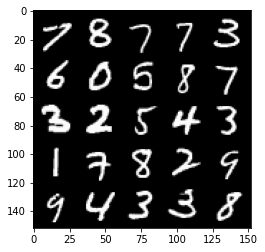

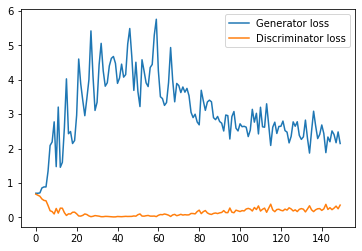

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.3106282861232756, Discriminator loss: 0.2909607709050179


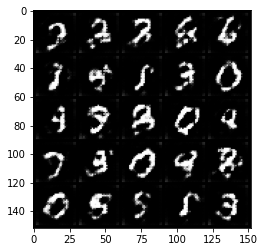

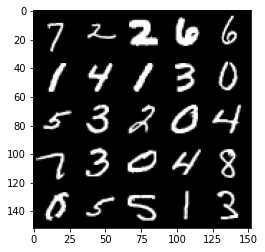

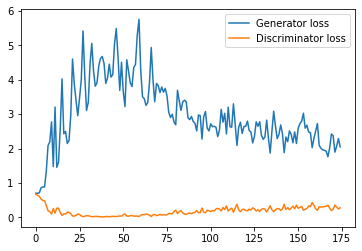

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.1071155192852022, Discriminator loss: 0.298745656222105


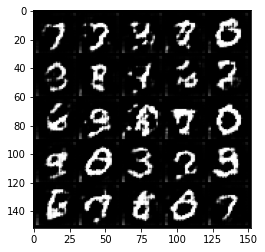

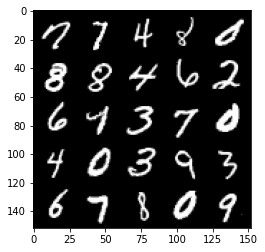

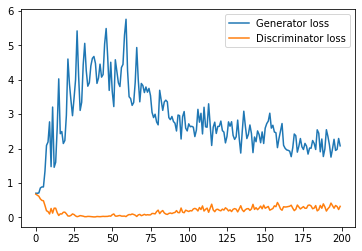

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 2.0971607508659362, Discriminator loss: 0.32653882378339766


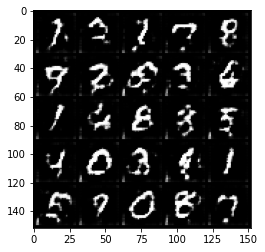

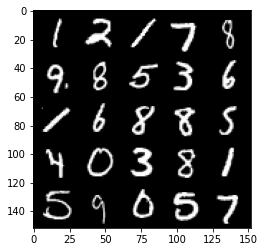

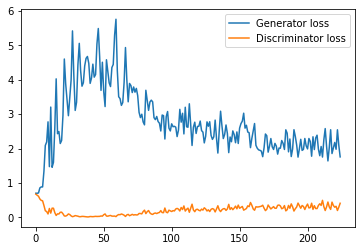

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 1.947742888689041, Discriminator loss: 0.3442013017833233


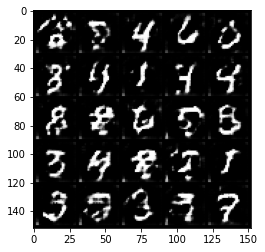

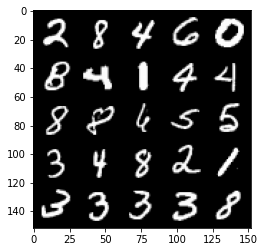

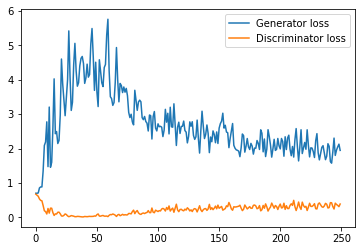

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 1.908327184677124, Discriminator loss: 0.3809550618827343


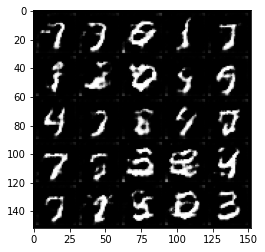

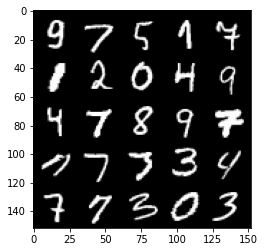

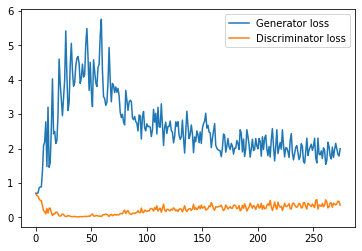

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 1.755435115814209, Discriminator loss: 0.4037251339256763


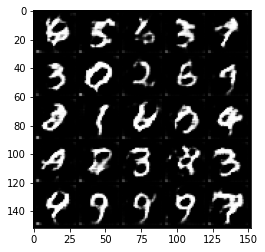

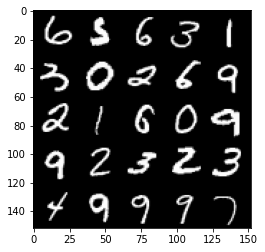

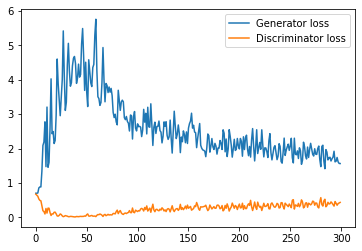

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 1.6053844277858733, Discriminator loss: 0.4444485159516334


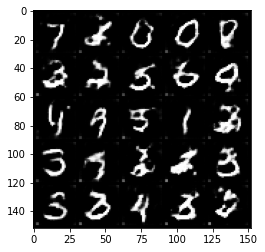

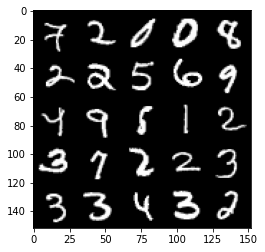

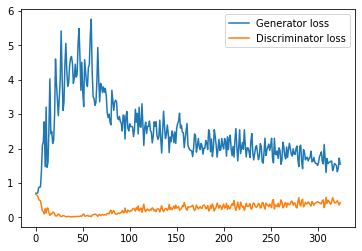

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 1.4858494956493378, Discriminator loss: 0.4502118495106697


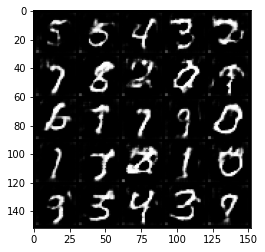

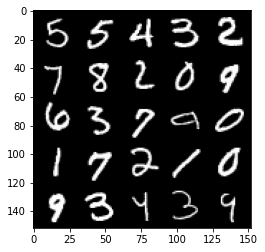

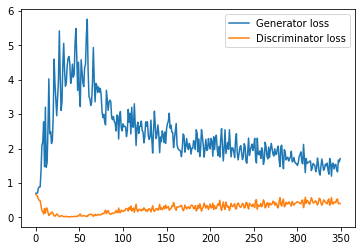

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 1.5016510059833528, Discriminator loss: 0.4690347870588303


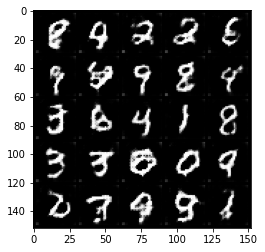

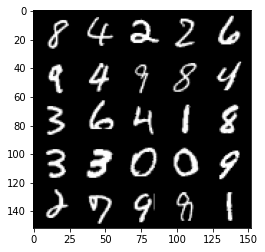

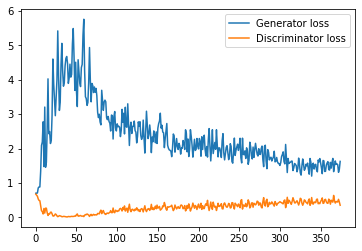

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 1.5115756331682204, Discriminator loss: 0.47932441198825837


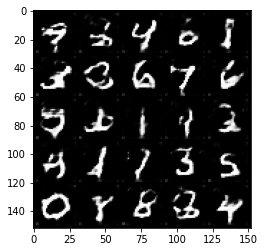

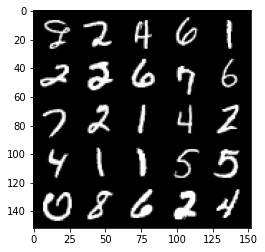

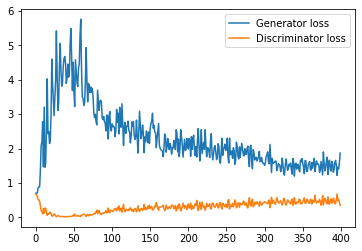

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 1.5026640300750733, Discriminator loss: 0.4926587049663067


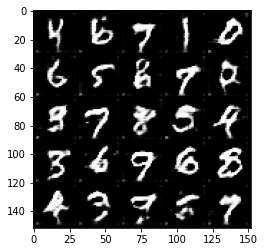

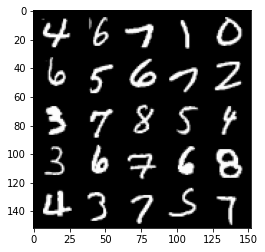

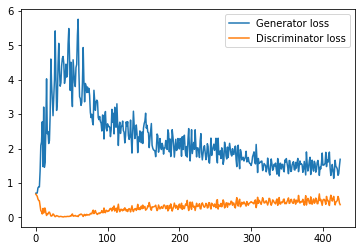

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 1.312247787475586, Discriminator loss: 0.5153848611712456


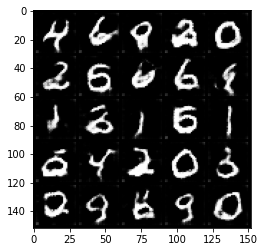

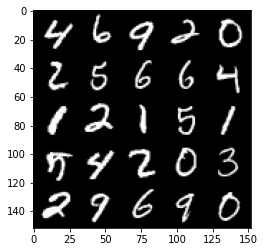

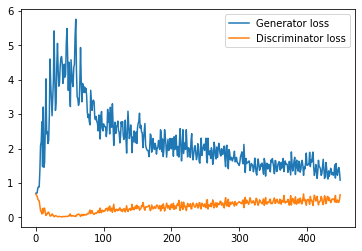

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 1.3097727272510529, Discriminator loss: 0.5174628053307533


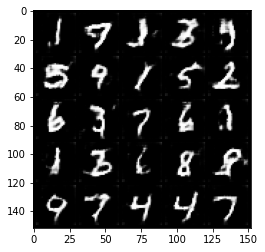

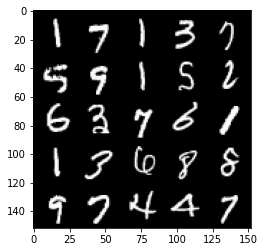

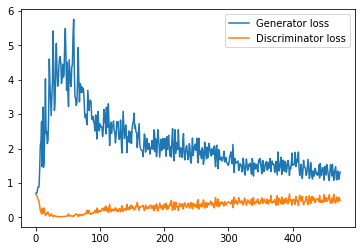

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)

        image_one_hot_labels = one_hot_labels[:, :, None, None]
        
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        # Update disc
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device = device)

        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)  # G(z|y)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)  # x|y

        disc_fake_pred = disc(fake_image_and_labels.detach())  # D(G(z|y))
        disc_real_pred = disc(real_image_and_labels)  # D(x|y)

        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2  
        disc_loss.backward(retain_graph = True)
        disc_opt.step()

        discriminator_losses += [disc_loss.item()]

        # Update gen
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)

        disc_fake_pred = disc(fake_image_and_labels)  # D(G(z|y))
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        generator_losses += [gen_loss.item()]

    # visualize the results
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, Discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label = "Generator loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label = "Discriminator loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1